# Пелевин RNN - тренировка модели

In [1]:
import os
import random

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn.functional as F

from torch.nn import Embedding, Linear, LSTM, Dropout

from IPython.display import clear_output

### Загрузка обучающего датасета (текста)

In [2]:
with open('pelevin-all_prepared.txt') as input_file:
    texts = input_file.read()[:-1].split('\n')

In [3]:
print(len(texts))

76275


In [4]:
texts[:10]

['Колдун Игнат и люди',
 'Сказочка',
 '4 мая 1912 года к колдуну Игнату пришел в гости протоиерей Арсеникум. Пока Игнат хлопотал с самоваром, доставал пряники, гость сморкался у вешалки, долго снимал калоши, крестился и вздыхал. Потом сел на краешек табурета, достал из-под рясы папку красного картона, раскрыл и развязно сказал Игнату:',
 '– Глянь-ка, чего я понаписал!',
 '– Интересно, – сказал Игнат, беря первый лист, – вслух читать?',
 '– Что ты! – испугано зашипел протоиерей. – Про себя!',
 'Игнат стал читать:',
 '«ОТКРОВЕНИЕ СВ. ФЕОКТИСТА»',
 '– «Люди! – сказал св. Феоктист, потрясая узловатым посохом. – Христос явился мне, истинно так. Он велел пойти к вам и извиниться. Ничего не вышло».',
 '– Ха-ха-ха! – засмеялся Игнат, а сам подумал: «Неспроста это». Но виду не подал.']

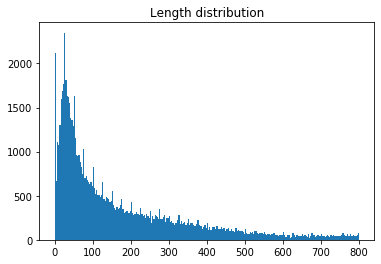

In [5]:
plt.title('Length distribution')
plt.hist(list(map(len, texts)), bins=256);

In [6]:
MAX_LEN = max(map(len,texts))

print(MAX_LEN)

800


### Загрузка токенов

In [7]:
with open('tokens.txt') as t_file:
    tokens_string = t_file.read()
tokens = list(tokens_string)

In [8]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}
num_tokens = len(tokens)

In [9]:
print(tokens)

[' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', '~', '©', '«', '®', '°', '»', 'À', 'É', 'Ñ', 'Ø', 'à', 'á', 'â', 'ä', 'ç', 'è', 'é', 'ë', 'ï', 'ó', 'ø', 'ü', 'ň', '́', 'α', 'γ', 'ε', 'μ', 'ς', 'σ', 'τ', 'Ё', 'Є', 'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ъ', 'Ы', 'Ь', 'Э', 'Ю', 'Я', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё', 'є', 'і', 'ї', 'ѣ', 'ה', 'ו', 'ז', 'ח', 'י', 'פ'

In [10]:
print(len(tokens))

214


### Функция преобразования токинизированного текста в тензор

In [11]:
def to_matrix(data, token_to_id, max_len=None, dtype='int32', batch_first = True):

    max_len = max_len or max(map(len, data))
    data_ix = np.zeros([len(data), max_len], dtype) + token_to_id[' ']

    for i in range(len(data)):
        line_ix = [token_to_id[c] for c in data[i]]
        data_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        data_ix = np.transpose(data_ix)

    return data_ix

### Определение модели

In [12]:
class PelevinRNN(torch.nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=100, rnn_num_units=512):
        super(self.__class__, self).__init__()
        self.emb = Embedding(num_tokens, emb_size)
        self.rnn = LSTM(emb_size, rnn_num_units, num_layers=3, batch_first=True)
        self.hid_to_logits = Linear(rnn_num_units, num_tokens)
        self.dropout = Dropout(p=0.6)

    def forward(self, x, hidden_state=None):
        x = self.dropout(self.emb(x))
        if hidden_state is not None:
            h_seq, new_hidden = self.rnn(x, hidden_state)
        else:
            h_seq, new_hidden = self.rnn(x)
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, new_hidden

In [13]:
model = PelevinRNN().cuda()
history = []

model.parameters

<bound method Module.parameters of PelevinRNN(
  (emb): Embedding(214, 100)
  (rnn): LSTM(100, 512, num_layers=3, batch_first=True)
  (hid_to_logits): Linear(in_features=512, out_features=214, bias=True)
  (dropout): Dropout(p=0.6, inplace=False)
)>

In [14]:
opt = torch.optim.Adam(model.parameters(), lr=0.001)

### Тренировочный цикл

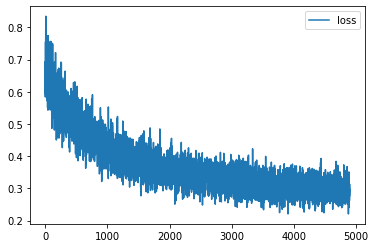

In [15]:
model = model.cuda()
model.train()

for i in range(5000):
    batch_ix = to_matrix(random.sample(texts, 128), token_to_id, max_len=MAX_LEN)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64).cuda()
    
    logp_seq, hid = model(batch_ix)
    
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))
    
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.cpu().numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history[100:], label='loss')
        plt.legend()
        plt.show()

### Сохранение весов модели

In [17]:
torch.save(model.state_dict(), 'model.lol')